In [10]:
import numpy as np
import matplotlib.pyplot as plt
from cv2 import xfeatures2d
import cv2

### 1. Keypoint Detection

Common schema:

1. Compute a saliency score for each pixel location based on the response to different mathematical operators.
2. Keep only the points that are local extrema.
3. For each keypoint estimate the ‘scale’ at which it is salient (scale invariance) and the orientation (rotation invariance).

In [11]:
image_target = cv2.imread('a1.jpeg', cv2.IMREAD_GRAYSCALE)
image_reference = cv2.imread('wild-boar.webp', cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create()
kp_ref = sift.detect(image_reference)

# Number of keypoints
print(len(kp_ref))

# Location of the keypoint
print(kp_ref[0].pt)

# Scale
print(kp_ref[0].size)

# Rotation
print(kp_ref[0].angle)

20667
(347.0815734863281, 1885.2562255859375)
5.825383186340332
11.171913146972656


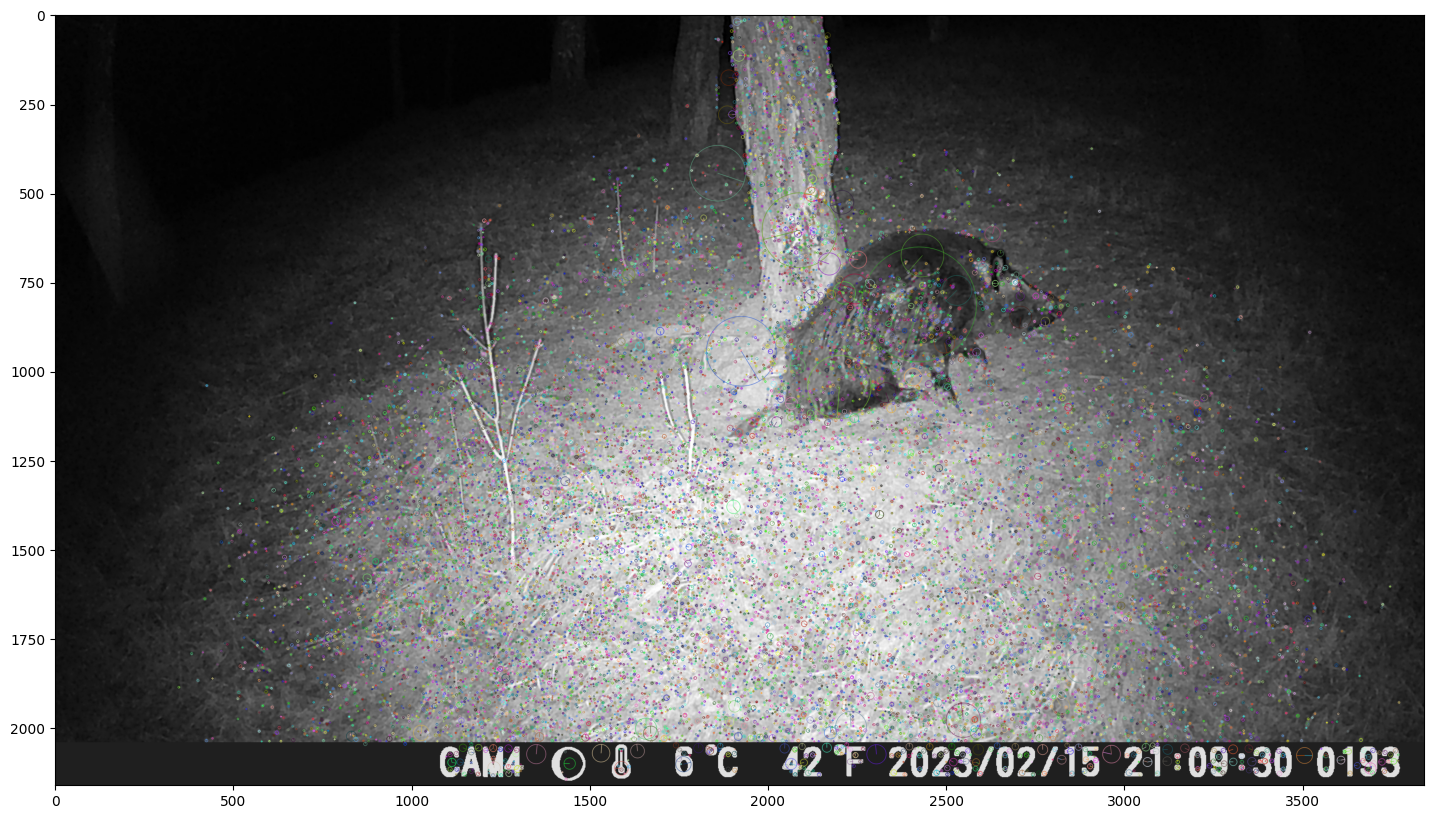

In [12]:
img_visualization = cv2.drawKeypoints(image_reference, kp_ref, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(20,10))
plt.imshow(img_visualization)
plt.show()

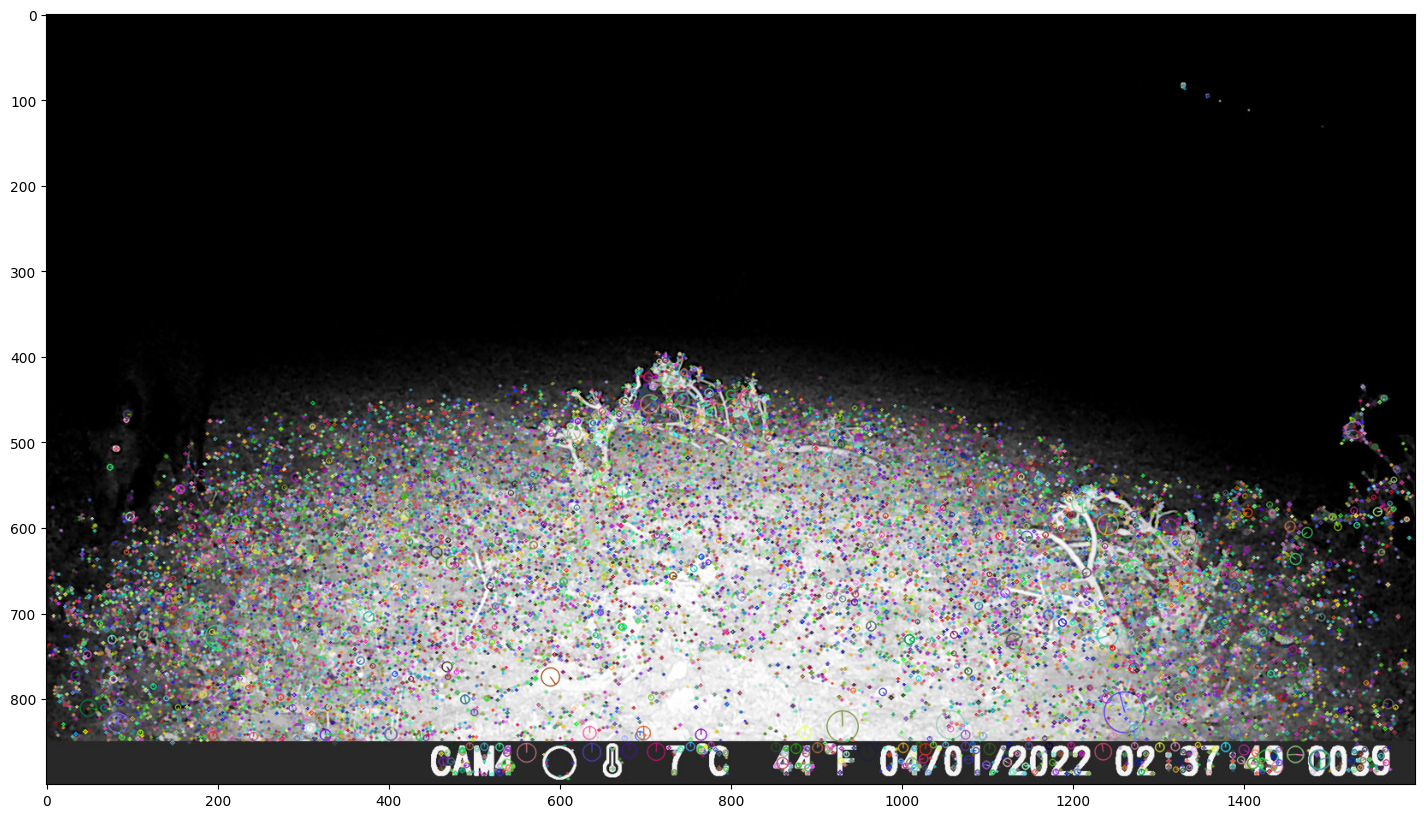

In [13]:
kp_target = sift.detect(image_target)

img = cv2.drawKeypoints(image_target,kp_target,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

### 2. Keypoints Description

Compute for each keypoint a unique description usually based on the nearby pixels.

A good keypoint descriptor should be:
* Repeatable: the descriptions computed at homologus points should be as similar as possible.
* Distinctive: capture the salient informations around the keypoint despite various nuisances (e.g. light changes).
* Compact: minimize memory occupancy to allow efficient matching.
* Fast: it is usually applied to hundred or thousand of keypoints in each image.

Different algorithms provides different descriptions, the common idea is to describe keypoints using an array (histogram) of values that encodes the appearance of its local neighborhood. The size of the support depends on the scale associated to the keypoint (i.e. scale invariance).

The histogram used for the description could be made of:
* floats: more distinctive, high memory footprint
* bits: less distinctive, small memory footprint (binary descriptors)


In [14]:
# Describing keypoints for query and train images
kp_ref, des_ref = sift.compute(image_reference, kp_ref)
kp_target, des_target = sift.compute(image_target, kp_target)

print("Number of keypoints: ", len(kp_ref))
print("Number of keypoints target: ", len(kp_target))
print("Number of ref descriptors: ", len(des_ref))
print("Dimensionality of a SIFT descriptor: ", des_ref[0].shape)
print("Type of the descriptor: ", des_ref[0].dtype)

Number of keypoints:  20667
Number of keypoints target:  17073
Number of ref descriptors:  20667
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


### 3. Feature Matching

Descriptors extracted from the scene are compared with those extracted from the models to find couples of similar ones. Classic Nearest Neighbour(NN) search problem.

In our scenario points are feature vectors and the distance function is Euclidean distance for floats or Hamming distance for bits.

Brute force matching is too slow => use efficient indexing such as KD-tree techniques borrowed from database management to speed up the search:
* Kd-tree - exact
* Locality-sensitive hashing (LSH) - for binary descriptor

For instance, we will use an approximate kd-tree algorithm from **FLANN** (Fast Library for Approximate Nearest Neighbors) included in OpenCV.

**FLANN** contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features.

In [15]:
# Scale
print(kp_ref[0].size)

# Rotation 
print(kp_ref[0].angle)

# Defining parameters for algorithm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search parameters
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 50)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params) # flann is used for the matching.

# Matching and finding the 2 closest elements for each query descriptor.
matches = flann.knnMatch(des_ref,des_target,k=2)
print(matches[0])

5.825383186340332
11.171913146972656
(< cv2.DMatch 0x7c90487bb250>, < cv2.DMatch 0x7c90487ba2f0>)


### Filtering False Matches in SIFT
To **filter** the matches, Lowe proposed to use a distance ratio test to try to eliminate false matches.

The **distance ratio** between the two nearest matches of a considered keypoint is computed and it is a good match when this value is below a threshold.

Indeed, this ratio allows helping to discriminate between **ambiguous matches** (distance ratio between the two nearest neighbors is close to one).

We iterate along all matches checking the distance ratio between the first and the second closest elements using 0.7 as distance ratio threshold:

In [16]:
good_matches = []
trs = 0.7
for m,n in matches:
    if m.distance < trs*n.distance:
        good_matches.append(m)
print(len(good_matches))

170


In [17]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 10
if len(good_matches)>MIN_MATCH_COUNT:
    # building the correspondences arrays of good matches
    src_pts = [ kp_ref[m.queryIdx].pt for m in good_matches ]
    src_pts = np.float32(src_pts)
    dst_pts = [ kp_target[m.trainIdx].pt for m in good_matches ]
    dst_pts = np.float32(dst_pts)
    print("Query points length", src_pts.shape)
    print("Refeerence points length", dst_pts.shape)

    # Using RANSAC to estimate a robust homography.
    # https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0)
    print("Homography", M)

    # Mask of discarded point used in visualization
    matchesMask = mask.ravel().tolist()
    print("Mask", matchesMask)

    # Corners of the query image
    print(image_reference.shape)
    h, w = image_reference.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ])

    # Projecting the corners into the train image
    contour = cv2.perspectiveTransform(np.array([pts]),M)

else:
    print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
    matchesMask = None

print(len(good_matches))

Query points length (170, 2)
Refeerence points length (170, 2)
Homography [[ 3.24889130e-01 -5.51936900e-02  1.16457207e+02]
 [-2.00920380e-03  2.34812649e-01  1.92482509e+02]
 [-2.28140412e-06 -1.02961441e-04  1.00000000e+00]]
Mask [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(2160, 3840)
170


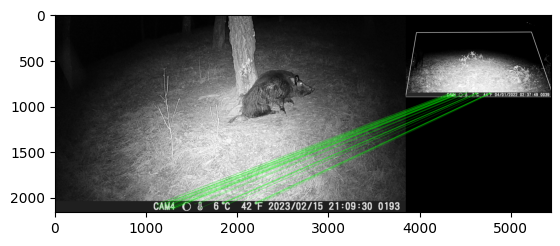

In [18]:
# Drawing the bounding box
img_train = cv2.polylines(image_target,[np.int32(contour)],True,(255,255,255),3, cv2.LINE_AA)

# Drawing the matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines
img_matches = cv2.drawMatches(image_reference,kp_ref,image_target,kp_target,good_matches,None,**draw_params)
plt.imshow(img_matches, 'gray')
plt.show()